In [1]:
import pickle
from pathlib import Path

import anndata as ad
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
analysis_path = Path("embryo")
data_path = Path("data") / "StereoSeq"

stereoseq_cell_h5ad = data_path / "E16.5_E1S3_cell_bin.h5ad"

In [3]:
# Palettes

kde_cmap = "magma"

In [4]:
segmentation = ad.read_h5ad(stereoseq_cell_h5ad)

In [5]:
with open(analysis_path / "embryo_supervised_wo_log.pickle", "rb") as file:
    supervised = pickle.load(file)

kde_per_celltype = pd.DataFrame(
    {
        "kde": supervised.total_mRNA_KDE.flatten(),
        "celltype": pd.Categorical.from_codes(
            supervised.celltype_map.ravel(), categories=supervised.celltypes
        ),
    }
).dropna()

celltype_threshold = (
    kde_per_celltype.groupby("celltype", observed=True).quantile(0.8)["kde"] / 3
).to_dict()

min_t = 0.9

celltype_threshold = {
    ct: (t if t > min_t else min_t) for ct, t in celltype_threshold.items()
}

supervised.filter_background(celltype_threshold)

In [6]:
with open(analysis_path / "embryo_unsupervised_resolution2.pickle", mode="rb") as out:
    unsupervised = pickle.load(out)

kde_per_celltype = pd.DataFrame(
    {
        "kde": unsupervised.total_mRNA_KDE.flatten(),
        "celltype": pd.Categorical.from_codes(
            unsupervised.celltype_map.ravel(), categories=unsupervised.celltypes
        ),
    }
).dropna()

celltype_threshold = (
    kde_per_celltype.groupby("celltype", observed=True).quantile(0.8)["kde"] / 3
).to_dict()

min_t = 0.9

celltype_threshold = {
    ct: (t if t > min_t else min_t) for ct, t in celltype_threshold.items()
}

unsupervised.filter_background(celltype_threshold)

In [7]:
cmap_supervised = dict(
    zip(
        segmentation.obs["annotation"].cat.categories,
        segmentation.uns["annotation_colors"],
    )
)

In [8]:
import colorcet as cc

cmap_denovo = dict(
    zip(
        unsupervised.celltypes,
        sns.color_palette(cc.glasbey, n_colors=len(unsupervised.celltypes)),
    )
)

In [9]:
# rotate and shift segmentation-based cell centers for plotting
segmentation.obsm["spatial"][:, 0] *= -1
segmentation.obsm["spatial"] -= segmentation.obsm["spatial"].min(axis=0)

In [10]:
plt.style.use("dark_background")

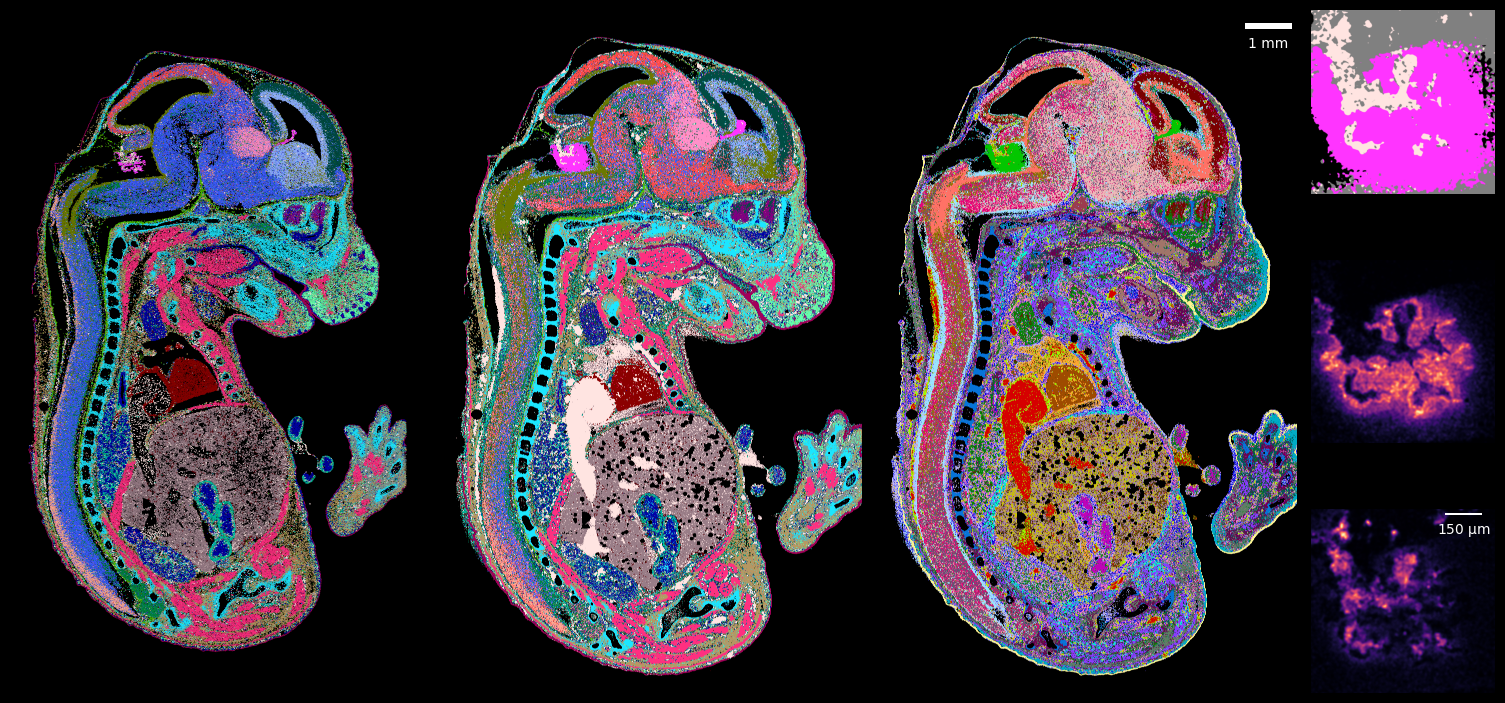

In [11]:
fig = plt.figure(figsize=(15, 8))

## Top
top = fig.subfigures(1, 2, width_ratios=[7, 1])

# whole embryo
axs = top[0].subplots(1, 3)

sns.scatterplot(
    x=segmentation.obsm["spatial"][:, 0],
    y=segmentation.obsm["spatial"][:, 1],
    hue=segmentation.obs["annotation"],
    palette=cmap_supervised,
    legend=False,
    linewidth=0,
    marker=".",
    s=2,
    ax=axs[0],
)
axs[0].set(aspect=1)


im = supervised.plot_celltypemap(cmap=cmap_supervised, return_img=True)
axs[1].imshow(im.transpose(1, 0, 2))


im = unsupervised.plot_celltypemap(cmap=cmap_denovo, return_img=True)
axs[2].imshow(im.transpose(1, 0, 2))
axs[2].add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0, "color": "w"}))


for i in range(axs.size):
    axs[i].set_axis_off()

# Choroid plexus
axs = top[1].subplots(3, 1, sharex=True, sharey=True)
im = supervised.plot_celltypemap(
    cmap={ct: cmap_supervised[ct] for ct in ["Choroid plexus", "Erythrocyte"]},
    crop=((5000, 6500), (4500, 6000)),
    return_img=True,
)
axs[0].imshow(im.transpose(1, 0, 2))

im = axs[1].imshow(
    supervised.kde(gene="Ttr").toarray()[5000:6500, 4500:6000], cmap=kde_cmap
)

im = axs[2].imshow(
    supervised.kde(gene="Hbb-bs").toarray()[5000:6500, 4500:6000], cmap=kde_cmap
)
axs[2].add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0, "color": "w"}))


for i in range(axs.size):
    axs[i].set_axis_off()

fig.tight_layout()

In [12]:
fig.savefig("figures/Fig_embryo_1.pdf", dpi=600)

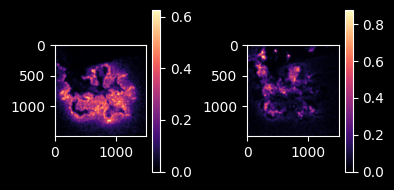

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

im = axs[0].imshow(
    supervised.kde(gene="Ttr").toarray()[5000:6500, 4500:6000], vmin=0, cmap=kde_cmap
)
fig.colorbar(im, ax=axs[0])

im = axs[1].imshow(
    supervised.kde(gene="Hbb-bs").toarray()[5000:6500, 4500:6000],
    vmin=0,
    cmap=kde_cmap,
)
fig.colorbar(im, ax=axs[1])

fig.tight_layout()

In [15]:
fig.savefig("figures/Fig_embryo_1_scales.pdf", dpi=600)

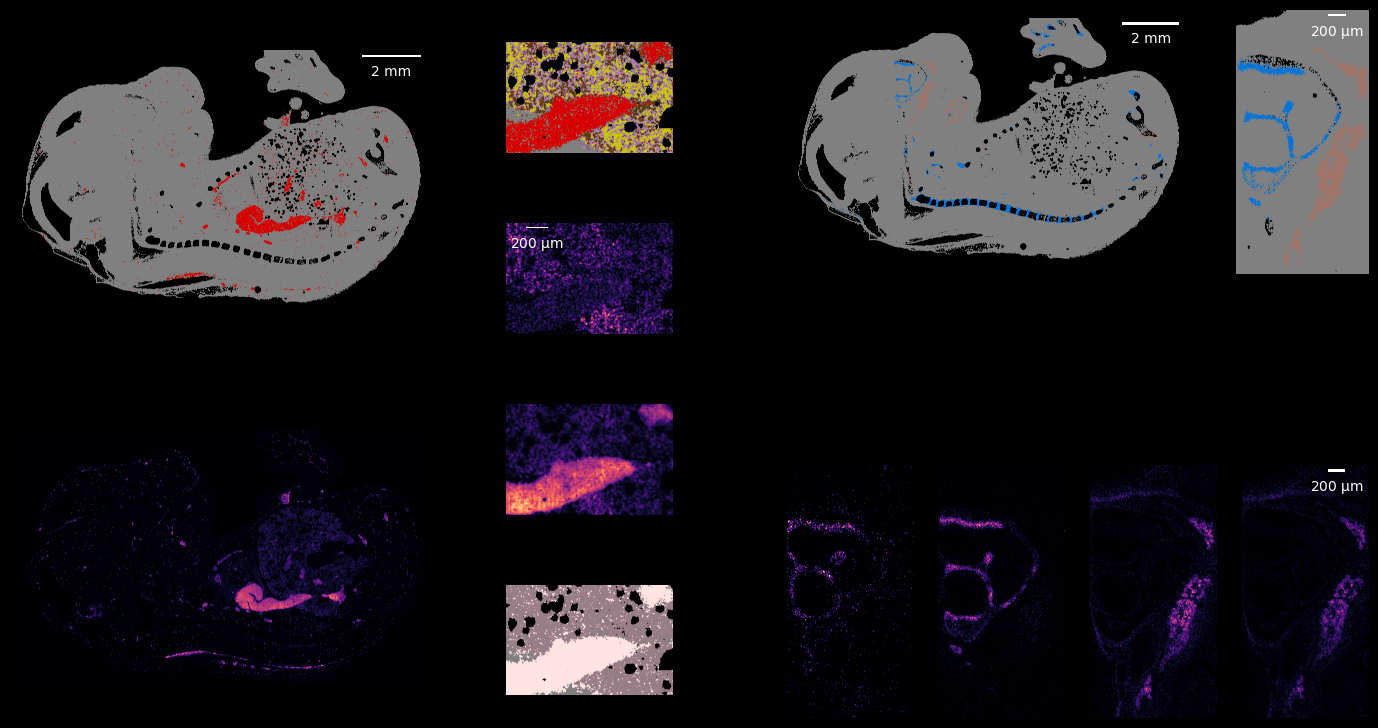

In [17]:
fig = plt.figure(figsize=(15, 9))

## Bottom
bottom = fig.subfigures(1, 3, width_ratios=[5, 2, 7])

# Blood
axs = bottom[0].subplots(2, 1)

im = unsupervised.plot_celltypemap(cmap={"13": cmap_denovo["13"]}, return_img=True)
axs[0].imshow(im, origin="lower")
axs[0].add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0, "color": "w"}))

axs[1].imshow(
    unsupervised.kde(gene="Hbb-bs").toarray().T, origin="lower", cmap=kde_cmap
)
# axs[1].add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0, "color": "w"}))


for i in range(axs.size):
    axs[i].set_axis_off()

# Spleen and liver
axs = bottom[1].subplots(4, 1, sharex=True, sharey=True)

im = unsupervised.plot_celltypemap(
    cmap={ct: cmap_denovo[ct] for ct in ["5", "13", "18", "21"]},
    return_img=True,
    crop=((18_000, 21_000), (5_250, 7_250)),
)
axs[0].imshow(im, origin="lower")

axs[1].imshow(
    unsupervised.kde(gene="Alb").toarray()[18_000:21_000, 5_250:7_250].T,
    origin="lower",
    cmap=kde_cmap,
)
axs[1].add_artist(
    ScaleBar(
        500, **{"units": "nm", "box_alpha": 0, "color": "w", "location": "upper left"}
    )
)

axs[2].imshow(
    unsupervised.kde(gene="Hbb-bs").toarray()[18_000:21_000, 5_250:7_250].T,
    origin="lower",
    cmap=kde_cmap,
)

im = supervised.plot_celltypemap(
    cmap={ct: cmap_supervised[ct] for ct in ["Erythrocyte", "Hepatocyte"]},
    return_img=True,
    crop=((18_000, 21_000), (5_250, 7_250)),
)
axs[3].imshow(im, origin="lower")

for i in range(axs.size):
    axs[i].set_axis_off()

## Chondro / ossification
chondro_figs = bottom[2].subfigures(2, 1)

# CT maps
axs = chondro_figs[0].subplots(1, 2, width_ratios=[3, 1])

im = unsupervised.plot_celltypemap(
    cmap={ct: cmap_denovo[ct] for ct in ["23", "28"]}, return_img=True
)
axs[0].imshow(im, origin="lower")
axs[0].add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0, "color": "w"}))

im = unsupervised.plot_celltypemap(
    cmap={ct: cmap_denovo[ct] for ct in ["23", "28"]},
    return_img=True,
    crop=((7_500, 10_500), (9_500, 15_500)),
)
axs[1].imshow(im, origin="lower")
axs[1].add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0, "color": "w"}))


for i in range(axs.shape[0]):
    axs[i].set_axis_off()

# Gene expression
axs = chondro_figs[1].subplots(1, 4)


for i, gene in enumerate(["Sox9", "Col2a1", "Col1a1", "Col1a2"]):
    axs[i].set_axis_off()
    im = axs[i].imshow(
        unsupervised.kde(gene=gene).toarray()[7_500:10_500, 9_500:15_500].T,
        origin="lower",
        cmap=kde_cmap,
        vmax=0.015 if gene == "Sox9" else None,
    )
    # chondro_figs[1].colorbar(im, ax=axs[i])

_ = axs[3].add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0, "color": "w"}))

In [18]:
fig.savefig("figures/Fig_embryo_2.pdf", dpi=600)

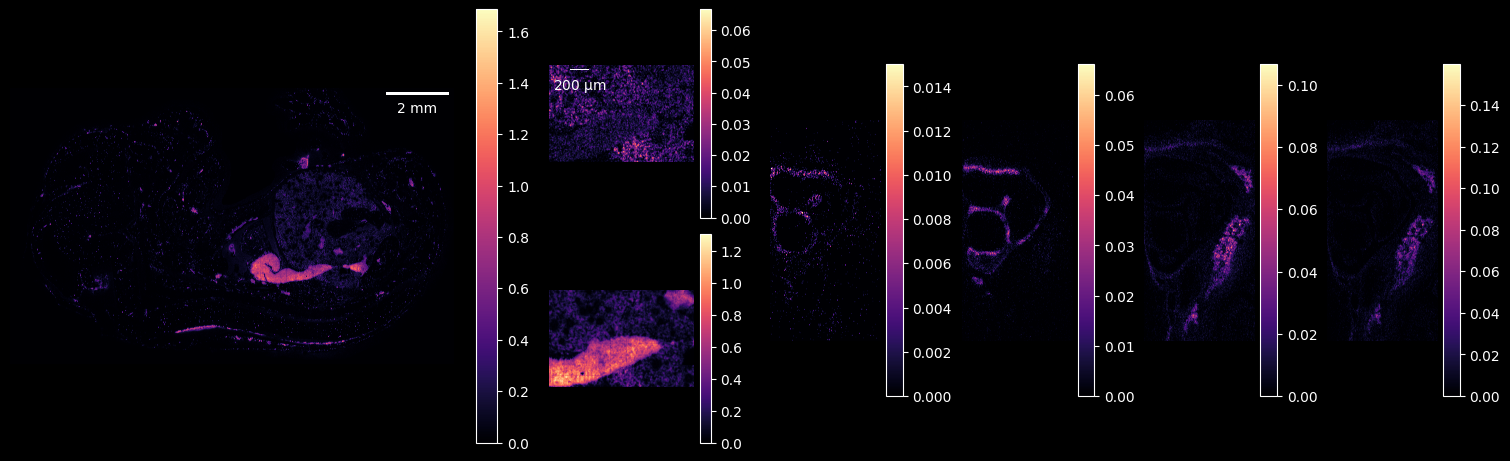

In [21]:
fig = plt.figure(figsize=(15, 4.5), layout="constrained")

## Bottom
bottom = fig.subfigures(1, 3, width_ratios=[5, 2, 7])

# Blood
ax = bottom[0].subplots()

im = ax.imshow(
    unsupervised.kde(gene="Hbb-bs").toarray().T, origin="lower", cmap=kde_cmap
)
bottom[0].colorbar(im, ax=ax)
ax.add_artist(ScaleBar(500, **{"units": "nm", "box_alpha": 0, "color": "w"}))
ax.set_axis_off()

# Spleen and liver
axs = bottom[1].subplots(2, 1)

im = axs[0].imshow(
    unsupervised.kde(gene="Alb").toarray()[18_000:21_000, 5_250:7_250].T,
    origin="lower",
    cmap=kde_cmap,
)
bottom[1].colorbar(im, ax=axs[0])
axs[0].add_artist(
    ScaleBar(
        500, **{"units": "nm", "box_alpha": 0, "color": "w", "location": "upper left"}
    )
)

im = axs[1].imshow(
    unsupervised.kde(gene="Hbb-bs").toarray()[18_000:21_000, 5_250:7_250].T,
    origin="lower",
    cmap=kde_cmap,
)
bottom[1].colorbar(im, ax=axs[1])

for i in range(axs.size):
    axs[i].set_axis_off()

# Chondro

axs = bottom[2].subplots(1, 4)

for i, gene in enumerate(["Sox9", "Col2a1", "Col1a1", "Col1a2"]):
    axs[i].set_axis_off()
    im = axs[i].imshow(
        unsupervised.kde(gene=gene).toarray()[7_500:10_500, 9_500:15_500].T,
        origin="lower",
        cmap=kde_cmap,
        vmax=0.015 if gene == "Sox9" else None,
    )
    bottom[2].colorbar(im, ax=axs[i])

In [22]:
fig.savefig("figures/Fig_embryo_2_scales.pdf", dpi=600)

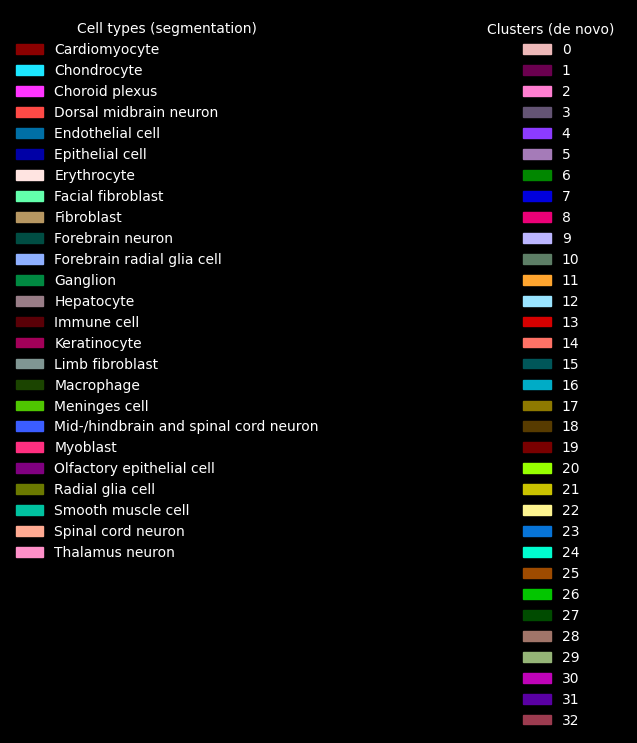

In [21]:
from matplotlib.patches import Patch

fig, axs = plt.subplots(1, 2, figsize=(7, 9))

supervised_legend = [Patch(color=c, label=lbl) for lbl, c in cmap_supervised.items()]
_ = axs[0].legend(
    handles=supervised_legend, title="Cell types (segmentation)", frameon=False
)
axs[0].set_axis_off()

cmap_denovo_sort = {
    ct: cmap_denovo[str(ct)] for ct in sorted([int(i) for i in cmap_denovo.keys()])
}

unsupervised_legend = [Patch(color=c, label=lbl) for lbl, c in cmap_denovo_sort.items()]
_ = axs[1].legend(
    handles=unsupervised_legend, title="Clusters (de novo)", frameon=False
)
axs[1].set_axis_off()

In [22]:
fig.savefig("figures/Fig_embryo_legend.pdf", dpi=600)